# Imports, install and mount

In [12]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# import sys
# my_local_drive='/content/gdrive/MyDrive/SL2024/datas'
# # Ajout du path pour les librairies, fonctions et données
# sys.path.append(my_local_drive)
# # Se positionner sur le répertoire associé
# %cd $my_local_drive
# %pwd
# print("DRIVE MOUNTED")

In [13]:
# ! pip install cuda
# ! pip install torch_geometric
# ! pip install dgl
# ! pip install nxontology
# ! pip install tensordict
# ! pip install numpy==1.22.1
# ! pip install pandas
# ! pip install tensorflow
# ! pip install scipy
# ! pip install pydantic
# ! pip install matplotlib

import random
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import os.path as osp
from torch_geometric.nn import ComplEx
from torch_geometric.data import Data
import pandas as pd
from tqdm import tqdm
from torch_geometric.loader import DataLoader
# import dgl
# import os
from torch.nn.functional import normalize
from tensordict.tensordict import TensorDict

from nxontology.imports import from_file
import tensorflow as tf

# Settings


In [14]:
# ComplEx embeddings :

hidden_channels = 10
batch_size = 4096
epochs = 1000
file_path = '/home/elliot/Documents/ESL2024/data/little_genes_to_phenotypes_iric.tsv'
# file_path = r"C:\Users\Admin\Desktop\Stage_LIRMM_2024\ESL2024\DATAS\little_Os_GO_iric.tsv"
# file_path = "/home/elliot/Documents/ESL2024/data/little_iric.tsv"

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu' # Tip : Use cpu for debugging
print(device)


# Losses tests :

n_negative_triplets_per_positive = 4 # Number of false negatives triples per positive triple in the dataset for losses tests.
url = "https://purl.obolibrary.org/obo/go/go-basic.json.gz" # Where should I look for GO ?

cpu


# Preparing ComplEx embeddings

## TSV to pyg.Data

We want :
- x (tensorised and processed node attributes) (1 for now)
- edge_index (a tensor of shape (num_edges, 2) indicates the source node index and the destination node index)
- edge_attr (a tensor that indicate the type of each edge)
- y (edge labels - optional, can be defined as node labels if needed)

## Reading and mapping graph

What we want : Create a Data object with all the properties I want to use later

	- x (tensorised and processed node attributes) (Not for now)
	- edge_index (a tensor of shape (num_edges, 2) indicates the source node index and the destination node index)
	- y (desired edge labels - optional, can be defined as node labels if needed) (Not for now)
	- any other things you want to use later

In [15]:
iric = pd.read_csv(file_path, delimiter='\t', names = ['subject', 'predicate','object'])
display(iric)

# Mapping entities to ids

entity_set = set(iric['object']).union(set(iric['subject']))
entity_to_mapping = {entity: int(i) for i, entity in enumerate(entity_set)}
relation_set = set(iric['predicate'])
relation_to_mapping = {relation: int(i) for i, relation in enumerate(relation_set)}

mapped_iric = iric.copy()
mapped_iric['object'] = mapped_iric['object'].apply(lambda x: entity_to_mapping[x])
mapped_iric['subject'] = mapped_iric['subject'].apply(lambda x: entity_to_mapping[x])
mapped_iric['predicate'] = mapped_iric['predicate'].apply(lambda x: relation_to_mapping[x])

display(mapped_iric)

print('OK')
print("Minima in mappings :")
print('subject :', min(mapped_iric['subject']))
print('predicate :',min(mapped_iric['predicate']))
print('object :',min(mapped_iric['object']))

print(entity_to_mapping)
print(relation_to_mapping)

mapping_to_entity = {v: k for k, v in entity_to_mapping.items()}
mapping_to_relation = {v: k for k, v in relation_to_mapping.items()}

print("Mapping to entity dict :",mapping_to_entity)
print("Mapping to relation dict",mapping_to_relation)

,subject,predicate,object
0,OsNippo01g010050,gene ontology,GO:0031267
1,OsNippo01g010050,gene ontology,GO:0006886
2,OsNippo01g010050,gene ontology,GO:0005622
3,OsNippo01g010050,gene ontology,GO:0005623
4,OsNippo01g010050,gene ontology,GO:0090630
...,...,...,...
9996,OsNippo01g223000,gene ontology,GO:0005784
9997,OsNippo01g223050,gene ontology,GO:0005634
9998,OsNippo01g223050,gene ontology,GO:0005737
9999,OsNippo01g223050,gene ontology,GO:0003676


,subject,predicate,object
0,1823,0,2960
1,1823,0,2154
2,1823,0,2237
3,1823,0,3294
4,1823,0,215
...,...,...,...
9996,1203,0,1271
9997,1955,0,2849
9998,1955,0,982
9999,1955,0,462


OK
Minima in mappings :
subject : 1
predicate : 0
object : 0
{'GO:0006739': 0, 'OsNippo01g077750': 1, 'GO:0047995': 2, 'GO:0102057': 3, 'OsNippo01g145000': 4, 'OsNippo01g097150': 5, 'GO:0008253': 6, 'GO:0016765': 7, 'GO:0051607': 8, 'OsNippo01g040950': 9, 'GO:0006355': 10, 'OsNippo01g138600': 11, 'OsNippo01g139700': 12, 'OsNippo01g041550': 13, 'GO:0016572': 14, 'OsNippo01g188950': 15, 'GO:0048034': 16, 'OsNippo01g063500': 17, 'OsNippo01g159600': 18, 'GO:0042500': 19, 'OsNippo01g087900': 20, 'GO:0045604': 21, 'OsNippo01g058800': 22, 'GO:0010015': 23, 'GO:0010038': 24, 'GO:0000347': 25, 'OsNippo01g065450': 26, 'GO:0035352': 27, 'OsNippo01g064000': 28, 'OsNippo01g102400': 29, 'GO:0010148': 30, 'GO:0080050': 31, 'GO:0002182': 32, 'GO:0061815': 33, 'GO:0009751': 34, 'GO:0007010': 35, 'GO:0009044': 36, 'GO:0000811': 37, 'OsNippo01g126650': 38, 'OsNippo01g036500': 39, 'GO:0008017': 40, 'OsNippo01g075800': 41, 'GO:0003899': 42, 'GO:0042221': 43, 'OsNippo01g095500': 44, 'GO:0048831': 45, 'GO:00

## Building init vars for Data :

In [16]:
# # Initial nodes states :
# x = torch.ones(len(entity_set), 1)  # Chaque nœud a 1 pour état initial
# print('X : \n',x)

# Edges index
heads = list(mapped_iric['subject'])
tails = list(mapped_iric['object'])
edge_index = torch.tensor([heads,tails], dtype=torch.long)
print('\nEDGE INDEX : \n',edge_index)

# edges states
edge_attributes = torch.tensor(mapped_iric['predicate'])
print('\nEDGES ATTRIBUTES : \n',edge_attributes)

iric_pyg = Data(
                # x = x,
                num_nodes = len(entity_set),
                edge_index = edge_index,
                edge_attr = edge_attributes)
print('\nDATASET :\n',iric_pyg)


print("\nDataset looks valid ? \n",iric_pyg.validate(raise_on_error=True))


EDGE INDEX : 
 tensor([[1823, 1823, 1823,  ..., 1955, 1955, 1955],
        [2960, 2154, 2237,  ...,  982,  462, 1514]])

EDGES ATTRIBUTES : 
 tensor([0, 0, 0,  ..., 0, 0, 0])

DATASET :
 Data(edge_index=[2, 10001], edge_attr=[10001], num_nodes=3343)

Dataset looks valid ? 
 True


## Setting up datas and model


## Splitting dataset

In [17]:
from torch_geometric.transforms import RandomLinkSplit

transform = RandomLinkSplit(
                            num_val = 0.1,
                            num_test = 0.1,
                            is_undirected=False,
                            add_negative_train_samples=False,
                            )

train_data, val_data, test_data = transform(iric_pyg)

print(f"Hole Dataset :\n {iric_pyg}\n\nTrain:\n{train_data}\n\nTest :\n{test_data}\n\nValidation :\n{val_data}")
# Il ne faut pas regarder num_edges parce que RLS cache les arêtes mais ne les sort pas du graph.
# print(f"Number of edges in datasets : \n  Hole Dataset : {iric_pyg.num_edges}\n\n  Train: {train_data.num_edges}\n\n  Test : {test_data.num_edges}\n\n  Validation : {val_data.num_edges}")
print(f"Number of edges in datasets : \n  Train: {list(train_data.edge_label.size())[0]}\n\n  Test : {list(test_data.edge_label.size())[0]}\n\n  Validation : {list(val_data.edge_label.size())[0]}")

train_data = train_data.to(device)
val_data = val_data.to(device)
test_data = test_data.to(device)

print('\n\n',train_data.num_nodes)
print(train_data.num_edge_types)
print(train_data.__dict__)
print(train_data.edge_index[0].size())
print(train_data.edge_index[1].size())
print(train_data.edge_attr.size())
print(train_data.edge_attr)
print(train_data.num_nodes)
print(train_data.edge_index.size()[1])

Hole Dataset :
 Data(edge_index=[2, 10001], edge_attr=[10001], num_nodes=3343)

Train:
Data(edge_index=[2, 8001], edge_attr=[8001], num_nodes=3343, edge_label=[8001], edge_label_index=[2, 8001])

Test :
Data(edge_index=[2, 9001], edge_attr=[9001], num_nodes=3343, edge_label=[2000], edge_label_index=[2, 2000])

Validation :
Data(edge_index=[2, 8001], edge_attr=[8001], num_nodes=3343, edge_label=[2000], edge_label_index=[2, 2000])
Number of edges in datasets : 
  Train: 8001

  Test : 2000

  Validation : 2000


 3343
1
{'_edge_attr_cls': <class 'torch_geometric.data.data.DataEdgeAttr'>, '_tensor_attr_cls': <class 'torch_geometric.data.data.DataTensorAttr'>, '_store': {'edge_index': tensor([[ 533, 1644, 1305,  ..., 3259, 1607, 2833],
        [1891, 2567, 1654,  ...,   91,  232, 1534]]), 'edge_attr': tensor([0, 0, 0,  ..., 0, 0, 0]), 'num_nodes': 3343, 'edge_label': tensor([1., 1., 1.,  ..., 1., 1., 1.]), 'edge_label_index': tensor([[ 533, 1644, 1305,  ..., 3259, 1607, 2833],
        [189

## Iniating model

In [18]:
complex_model = ComplEx(
    num_nodes=train_data.num_nodes,
    # num_relations=train_data.num_edge_types,
    num_relations = train_data.edge_index.size()[1],
    hidden_channels=hidden_channels,
).to(device)

head_index = train_data.edge_index[0]
tail_index = train_data.edge_index[1]
rel_type = train_data.edge_attr

loader = complex_model.loader(
    head_index = head_index,
    tail_index = tail_index,
    rel_type = rel_type,
    batch_size=batch_size,
    shuffle=True,
    # neg_sampling = 4
)

optimizer = optim.Adam(complex_model.parameters(),
                      #  lr=0.01, weight_decay=1e-6
                       )

## Training ComplEx

In [19]:
@torch.no_grad()
def test(data):
    complex_model.eval()
    return complex_model.test(
        head_index=test_data.edge_index[0],
        tail_index=test_data.edge_index[1],
        rel_type=test_data.edge_attr,
        batch_size=1000,
        k=10,
    )

def train():
    complex_model.train()
    total_loss = total_examples = 0

    for head_index, rel_type, tail_index in loader:
        optimizer.zero_grad()
        loss = complex_model.loss(head_index, rel_type, tail_index)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * head_index.numel()
        total_examples += head_index.numel()
    return total_loss / total_examples

torch.set_grad_enabled(True)
complex_model.to(device)

complex_model.reset_parameters()


start_rank, start_mrr, start_hits_at_10 = test(test_data)
print(f'Start Test Mean Rank: {start_rank:.2f}, Start Test MRR: {start_mrr:.4f}, '
      f'Start Test Hits@10: {start_hits_at_10:.4f}')

losses = []
for epoch in range(1, epochs):
    loss = train()
    losses.append(loss)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    if epoch % 500 == 0:
        rank, mrr, hits = test(val_data)
        print(f'Epoch: {epoch:03d}, Val Mean Rank: {rank:.2f}',
              f'Val MRR: {mrr:.4f}, Val Hits@10: {hits:.4f}')

rank, mrr, hits_at_10 = test(test_data)

print(f'Start Test Mean Rank: {start_rank:.2f}, Start Test MRR: {start_mrr:.4f}, '
      f'Start Test Hits@10: {start_hits_at_10:.4f}')
print(f'Final Test Mean Rank: {rank:.2f}, Final Test MRR: {mrr:.4f}, '
      f'Final Test Hits@10: {hits_at_10:.4f}')

torch.set_grad_enabled(False)

100%|██████████| 9001/9001 [00:08<00:00, 1059.80it/s]


Start Test Mean Rank: 1660.20, Start Test MRR: 0.0028, Start Test Hits@10: 0.0031
Epoch: 001, Loss: 0.6931
Epoch: 002, Loss: 0.6931
Epoch: 003, Loss: 0.6931
Epoch: 004, Loss: 0.6931
Epoch: 005, Loss: 0.6931
Epoch: 006, Loss: 0.6931
Epoch: 007, Loss: 0.6931
Epoch: 008, Loss: 0.6931
Epoch: 009, Loss: 0.6931
Epoch: 010, Loss: 0.6931
Epoch: 011, Loss: 0.6931
Epoch: 012, Loss: 0.6931
Epoch: 013, Loss: 0.6931
Epoch: 014, Loss: 0.6931
Epoch: 015, Loss: 0.6931
Epoch: 016, Loss: 0.6931
Epoch: 017, Loss: 0.6930
Epoch: 018, Loss: 0.6930
Epoch: 019, Loss: 0.6930
Epoch: 020, Loss: 0.6930
Epoch: 021, Loss: 0.6929
Epoch: 022, Loss: 0.6929
Epoch: 023, Loss: 0.6929
Epoch: 024, Loss: 0.6928
Epoch: 025, Loss: 0.6928
Epoch: 026, Loss: 0.6927
Epoch: 027, Loss: 0.6926
Epoch: 028, Loss: 0.6926
Epoch: 029, Loss: 0.6925
Epoch: 030, Loss: 0.6924
Epoch: 031, Loss: 0.6923
Epoch: 032, Loss: 0.6922
Epoch: 033, Loss: 0.6920
Epoch: 034, Loss: 0.6919
Epoch: 035, Loss: 0.6918
Epoch: 036, Loss: 0.6916
Epoch: 037, Loss: 

100%|██████████| 9001/9001 [00:08<00:00, 1057.93it/s]


Epoch: 500, Val Mean Rank: 86.59 Val MRR: 0.2200, Val Hits@10: 0.5475
Epoch: 501, Loss: 0.1677
Epoch: 502, Loss: 0.1681
Epoch: 503, Loss: 0.1672
Epoch: 504, Loss: 0.1623
Epoch: 505, Loss: 0.1611
Epoch: 506, Loss: 0.1631
Epoch: 507, Loss: 0.1604
Epoch: 508, Loss: 0.1622
Epoch: 509, Loss: 0.1643
Epoch: 510, Loss: 0.1641
Epoch: 511, Loss: 0.1602
Epoch: 512, Loss: 0.1598
Epoch: 513, Loss: 0.1619
Epoch: 514, Loss: 0.1573
Epoch: 515, Loss: 0.1571
Epoch: 516, Loss: 0.1602
Epoch: 517, Loss: 0.1572
Epoch: 518, Loss: 0.1534
Epoch: 519, Loss: 0.1558
Epoch: 520, Loss: 0.1595
Epoch: 521, Loss: 0.1546
Epoch: 522, Loss: 0.1549
Epoch: 523, Loss: 0.1534
Epoch: 524, Loss: 0.1526
Epoch: 525, Loss: 0.1577
Epoch: 526, Loss: 0.1510
Epoch: 527, Loss: 0.1519
Epoch: 528, Loss: 0.1521
Epoch: 529, Loss: 0.1499
Epoch: 530, Loss: 0.1483
Epoch: 531, Loss: 0.1452
Epoch: 532, Loss: 0.1443
Epoch: 533, Loss: 0.1431
Epoch: 534, Loss: 0.1429
Epoch: 535, Loss: 0.1499
Epoch: 536, Loss: 0.1466
Epoch: 537, Loss: 0.1482
Epoch

100%|██████████| 9001/9001 [00:08<00:00, 1067.15it/s]

Start Test Mean Rank: 1660.20, Start Test MRR: 0.0028, Start Test Hits@10: 0.0031
Final Test Mean Rank: 75.25, Final Test MRR: 0.2793, Final Test Hits@10: 0.7038


## Testing ComplEx

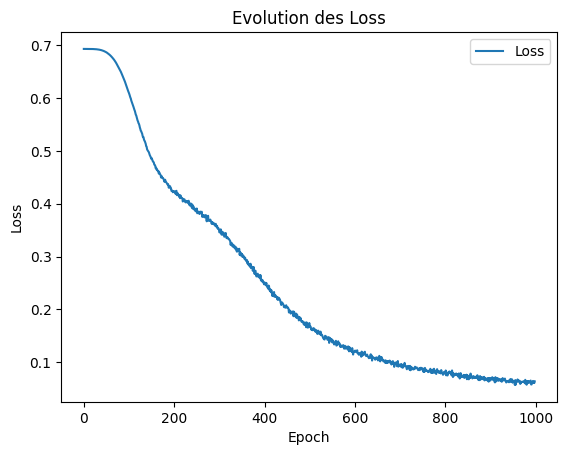

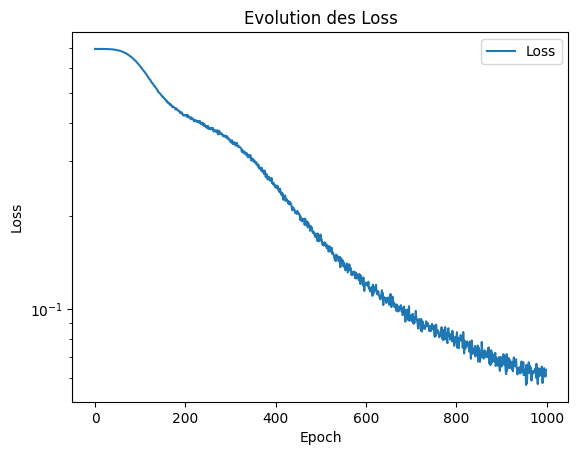

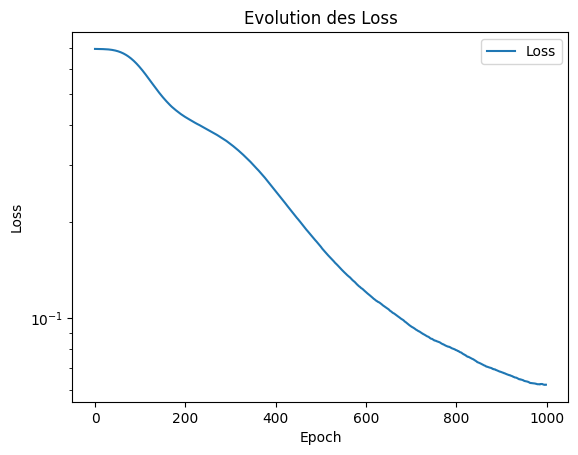

In [20]:
def plot_loss(loss_list):
    plt.plot(loss_list, label='Loss')
    plt.title('Evolution des Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_loss_log(loss_list):
    plt.semilogy(loss_list, label='Loss')
    plt.title('Evolution des Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def running_mean(list,
                 half_window: int # Number of elements that the function will consider 
                                  # ahead and behind the pos X to calculate running mean at X.
                 ):

    running_means = []

    for i in range(0,len(list)):

        left_bound = max(0,i-half_window)
        right_bound = min(len(list)-1, i + half_window)
        sublist = list[left_bound:right_bound+1]
        running_means.append(sum(sublist)/len(sublist))

    return running_means

plot_loss(losses)
plot_loss_log(losses)
plot_loss_log(running_mean(losses, 30))

In [63]:
complex_model.to('cpu')
torch.set_grad_enabled(False)

# Is complex_model coherent ?
iric_first_line = iric.iloc[0].tolist()
map_tail = entity_to_mapping[iric_first_line[0]]
map_head = entity_to_mapping[iric_first_line[2]]
map_rel = relation_to_mapping[iric_first_line[1]]

print("Good score should appear here :")
print(complex_model(torch.tensor(map_tail),torch.tensor(map_rel),torch.tensor(map_head)))



print("Bad scores should appear here :")
print(complex_model(torch.tensor(random.choice(list(mapping_to_entity.keys()))),torch.tensor(0),torch.tensor(random.choice(list(mapping_to_entity.keys())))))
print(complex_model(torch.tensor(random.choice(list(mapping_to_entity.keys()))),torch.tensor(0),torch.tensor(random.choice(list(mapping_to_entity.keys())))))

Good score should appear here :
tensor(-0.0676)
Bad scores should appear here :
tensor(-9.3736)
tensor(-4.1715)


## Making dict for association of embeddings and IDs (GO:XXXX)

In [22]:
model_save_path = "TestComplEx"
loc_path = %pwd
torch.save(complex_model.state_dict(), model_save_path)
print(f'Model saved at {loc_path}/{model_save_path}')

Model saved at /home/elliot/Documents/ESL2024/code/TestComplEx


Attributs pour accéder aux embeddings :

        head_re = self.node_emb(head_index)
        head_im = self.node_emb_im(head_index)
        rel_re = self.rel_emb(rel_type)
        rel_im = self.rel_emb_im(rel_type)
        tail_re = self.node_emb(tail_index)
        tail_im = self.node_emb_im(tail_index)

In [23]:
# Extracting embeddings for each entity and relation in dicts.

entities_mapping_to_embedding = {}
relation_mapping_to_embedding = {}

for entity in entity_set:
    entity_id = entity_to_mapping[entity]

    real_part = complex_model.node_emb(torch.tensor(entity_id))
    im_part = complex_model.node_emb_im(torch.tensor(entity_id))

    embedding = torch.cat((real_part, im_part))

    entities_mapping_to_embedding[entity_id] = embedding

for relation in relation_set:
    relation_id = relation_to_mapping[relation]

    real_part = complex_model.rel_emb(torch.tensor(relation_id))
    im_part = complex_model.rel_emb_im(torch.tensor(relation_id))

    embedding = torch.cat((real_part, im_part))

    relation_mapping_to_embedding[relation_id] = embedding

In [24]:
relation_mapping_to_embedding

{0: tensor([ 1.3577, -1.9226, -1.9085, -2.0126,  1.3300,  1.3768,  1.3627, -1.6062,
         -2.0305,  1.3239, -1.4170, -1.5822, -1.4825,  1.5424,  1.4265,  1.3160,
         -1.4388, -1.5233,  1.6286,  1.3994])}

In [25]:
# Making the reverse dicts :

entities_embedding_to_mapping ={v: k for k, v in entities_mapping_to_embedding.items()}
relation_embedding_to_mapping = {v: k for k, v in relation_mapping_to_embedding.items()}

# Quick check :

def get_key_value_pair(input_dict, i = 0):
    key = list(input_dict.keys())[i]
    value = input_dict[key]
    return key, value
K = get_key_value_pair(entities_mapping_to_embedding)[0]
V = get_key_value_pair(entities_mapping_to_embedding)[1]
print(f"First key-value pear in entities_mapping_to_embedding :\nKey={K}\nValue={V}")
print(f"And the pair in the symmetric dictentities_embedding_to_mapping :\nKey={V}\nValue={entities_embedding_to_mapping[V]} ")

First key-value pear in entities_mapping_to_embedding :
Key=0
Value=tensor([ 0.5816, -0.2195, -0.7261, -0.5567,  0.0088,  0.4558, -0.1353, -0.1983,
         0.5658, -0.0231,  0.1338, -0.3923,  0.8884,  0.7201, -0.2510, -0.2640,
         0.5867,  0.5777, -0.5688,  0.6123])
And the pair in the symmetric dictentities_embedding_to_mapping :
Key=tensor([ 0.5816, -0.2195, -0.7261, -0.5567,  0.0088,  0.4558, -0.1353, -0.1983,
         0.5658, -0.0231,  0.1338, -0.3923,  0.8884,  0.7201, -0.2510, -0.2640,
         0.5867,  0.5777, -0.5688,  0.6123])
Value=0 


In [26]:
relation_embedding_to_mapping 

{tensor([ 1.3577, -1.9226, -1.9085, -2.0126,  1.3300,  1.3768,  1.3627, -1.6062,
         -2.0305,  1.3239, -1.4170, -1.5822, -1.4825,  1.5424,  1.4265,  1.3160,
         -1.4388, -1.5233,  1.6286,  1.3994]): 0}

In [27]:
# Making {embedding : 'GOXXXX'} dicts and their symmetrics, {'GOXXXX': embedding} for both entities and relations.

entity_embedding_to_ID=dict()
for ID in entity_to_mapping.keys():
    map = entity_to_mapping[ID]
    embed = entities_mapping_to_embedding[map]
    entity_embedding_to_ID[embed]=ID

entities_embedding_to_name = {v: k for k,v in entity_embedding_to_ID.items()}

relation_embedding_to_ID=dict()
for ID in relation_to_mapping.keys():
    map = relation_to_mapping[ID]
    embed = relation_mapping_to_embedding[map]
    relation_embedding_to_ID[embed]=ID

entities_embedding_to_name = {v: k for k,v in relation_embedding_to_ID.items()}

In [28]:
print(relation_embedding_to_mapping) 
print(entities_embedding_to_name)

{tensor([ 1.3577, -1.9226, -1.9085, -2.0126,  1.3300,  1.3768,  1.3627, -1.6062,
        -2.0305,  1.3239, -1.4170, -1.5822, -1.4825,  1.5424,  1.4265,  1.3160,
        -1.4388, -1.5233,  1.6286,  1.3994]): 0}
{'gene ontology': tensor([ 1.3577, -1.9226, -1.9085, -2.0126,  1.3300,  1.3768,  1.3627, -1.6062,
        -2.0305,  1.3239, -1.4170, -1.5822, -1.4825,  1.5424,  1.4265,  1.3160,
        -1.4388, -1.5233,  1.6286,  1.3994])}


## Making dict of possibles tails for (head, relation) couples

In [29]:
possibles_tails: dict = {}
for index, row in iric.iterrows():
    head, rel, tail = row.iloc[0], row.iloc[1], row.iloc[2]
    hr = (head, rel)
    if hr not in possibles_tails:
        possibles_tails[hr]=[tail]
    else :
        possibles_tails[hr].append(tail)

print(possibles_tails)
    

{('OsNippo01g010050', 'gene ontology'): ['GO:0031267', 'GO:0006886', 'GO:0005622', 'GO:0005623', 'GO:0090630', 'GO:0043087', 'GO:0005096'], ('OsNippo01g010100', 'gene ontology'): ['GO:0020037', 'GO:0016705', 'GO:0055114', 'GO:0004497', 'GO:0005506', 'GO:0009055'], ('OsNippo01g010200', 'gene ontology'): ['GO:0055114', 'GO:0016722', 'GO:0005507', 'GO:0016491', 'GO:0005886', 'GO:0009506', 'GO:0046658'], ('OsNippo01g010300', 'gene ontology'): ['GO:0016020'], ('OsNippo01g010350', 'gene ontology'): ['GO:0003676'], ('OsNippo01g010400', 'gene ontology'): ['GO:0016020'], ('OsNippo01g010450', 'gene ontology'): ['GO:0006412', 'GO:0019843', 'GO:0005622', 'GO:0003723', 'GO:0042542', 'GO:0000028', 'GO:0022627', 'GO:0009651', 'GO:0003735', 'GO:0009414', 'GO:0009737', 'GO:0050832', 'GO:0003729', 'GO:0005840', 'GO:0015935'], ('OsNippo01g010550', 'gene ontology'): ['GO:0005783', 'GO:0016829', 'GO:0006888', 'GO:0051788', 'GO:0006629', 'GO:0016020', 'GO:0006635', 'GO:0043161', 'GO:0050832', 'GO:0009751', 

# Preparing a dataset to investigate modified loss

## Making negative triples

On va créer n triplets négatifs par triplet positif.
Pour créer un triplet négatif à partir d'un triplet positif, on remplace la tête de ce dernier par une entité aléatoire.
Il y a une chance de créer des faux négatifs, mais comme chaque entité apparait moins d'une fois sur 1000 dans le jeu de données, cette probabilité reste faible.

In [30]:
# Nombre d'apparition de chaque entité dans iric :
# mapped_iric.hist(column="subject", bins = len(list(entity_set)))

In [31]:
# Adding negative triples to our dataset.
# This is a naive implementation, it could be accelerated.

import numpy as np
from tqdm import tqdm
import random

def generate_negative_triples(df, number_of_false_per_true, falsify_relation = False):

    negative_triples = []

    possible_heads = list(set(list(df.iloc[:,0])))
    possible_relations = list(set(list(df.iloc[:,1])))
    possible_tails = list(set(list(df.iloc[:,2])))

    for index, row in tqdm(df.iterrows(), total=len(df), desc="Generating Negative Triples"):
        for i in range(number_of_false_per_true):

            if falsify_relation :
                r = np.random.randint(2) 
            else :
                r = np.random.randint(3)

            if r == 0:
                random_head = random.choice(possible_heads)
                negative_triples.append([random_head, row[1], row[2]])

            elif r == 1:
                random_tail = random.choice(possible_tails)
                negative_triples.append([row[0], row[1], random_tail])

            elif r == 2:
                random_relation = random.choice(possible_relations)
                negative_triples.append([row[0], random_relation, row[2]])
                
    negative_triples_df = pd.DataFrame(negative_triples, columns=df.columns)
    return pd.DataFrame(negative_triples_df)


def generate_negative_triples_HEAD_ONLY(df, number_of_false_per_true, falsify_relation = False):

    original = df.copy()

    # Coppying n times the original DF in a DF named falses
    falses = df.copy()
    for i in range(number_of_false_per_true-1):
        falses = pd.concat([falses,original])

    # Shuffling heads column
    falses.iloc[:,2]=falses.iloc[:,2].sample(frac=1).values
    
    return falses

negatives_from_iric = generate_negative_triples_HEAD_ONLY(mapped_iric, n_negative_triplets_per_positive)

display(mapped_iric)
display(negatives_from_iric)

,subject,predicate,object
0,1823,0,2960
1,1823,0,2154
2,1823,0,2237
3,1823,0,3294
4,1823,0,215
...,...,...,...
9996,1203,0,1271
9997,1955,0,2849
9998,1955,0,982
9999,1955,0,462


,subject,predicate,object
0,1823,0,2154
1,1823,0,1784
2,1823,0,3030
3,1823,0,523
4,1823,0,616
...,...,...,...
9996,1203,0,1146
9997,1955,0,1237
9998,1955,0,2246
9999,1955,0,913


In [32]:
print(negatives_from_iric.iloc[:,2])

0        2154
1        1784
2        3030
3         523
4         616
         ... 
9996     1146
9997     1237
9998     2246
9999      913
10000    1877
Name: object, Length: 40004, dtype: int64


In [33]:
# Adding lables to our datas.
# 1 : the link exists ; 0 : the link do not exists.

labelled_mapped_iric = mapped_iric.copy()
labelled_mapped_iric['label']=1
labelled_negatives_from_iric = negatives_from_iric.copy()
labelled_negatives_from_iric['label']=0
mapped_iric_with_negatives = pd.concat([labelled_mapped_iric, labelled_negatives_from_iric])
display(mapped_iric_with_negatives)

,subject,predicate,object,label
0,1823,0,2960,1
1,1823,0,2154,1
2,1823,0,2237,1
3,1823,0,3294,1
4,1823,0,215,1
...,...,...,...,...
9996,1203,0,1146,0
9997,1955,0,1237,0
9998,1955,0,2246,0
9999,1955,0,913,0


In [34]:
shuffled_mapped_iric_with_negatives = mapped_iric_with_negatives.sample(frac=1).reset_index(drop=True)
display(shuffled_mapped_iric_with_negatives)

,subject,predicate,object,label
0,2219,0,1120,0
1,1371,0,2016,0
2,2731,0,2011,0
3,1791,0,1654,0
4,2669,0,1075,0
...,...,...,...,...
50000,1548,0,2016,0
50001,1397,0,751,0
50002,1558,0,571,1
50003,2364,0,1146,0


## Mapped datas to embedded datas

In [35]:
display(shuffled_mapped_iric_with_negatives)

tensorized_triples = shuffled_mapped_iric_with_negatives.copy()
tensorized_triples['object'] = tensorized_triples['object'].apply(lambda x: entities_mapping_to_embedding[x])
tensorized_triples['subject'] = tensorized_triples['subject'].apply(lambda x: entities_mapping_to_embedding[x])
tensorized_triples['predicate'] = tensorized_triples['predicate'].apply(lambda x: relation_mapping_to_embedding[x])
display(tensorized_triples)

,subject,predicate,object,label
0,2219,0,1120,0
1,1371,0,2016,0
2,2731,0,2011,0
3,1791,0,1654,0
4,2669,0,1075,0
...,...,...,...,...
50000,1548,0,2016,0
50001,1397,0,751,0
50002,1558,0,571,1
50003,2364,0,1146,0


,subject,predicate,object,label
0,"[tensor(0.5166), tensor(-1.2521), tensor(-0.01...","[tensor(1.3577), tensor(-1.9226), tensor(-1.90...","[tensor(-0.1353), tensor(-0.6731), tensor(-0.3...",0
1,"[tensor(-0.2081), tensor(-1.3303), tensor(0.02...","[tensor(1.3577), tensor(-1.9226), tensor(-1.90...","[tensor(0.9951), tensor(0.2058), tensor(-0.912...",0
2,"[tensor(-0.6379), tensor(-1.1775), tensor(0.91...","[tensor(1.3577), tensor(-1.9226), tensor(-1.90...","[tensor(-0.4775), tensor(-0.7763), tensor(0.34...",0
3,"[tensor(-0.0993), tensor(-1.0355), tensor(0.57...","[tensor(1.3577), tensor(-1.9226), tensor(-1.90...","[tensor(0.4315), tensor(-1.5252), tensor(0.108...",0
4,"[tensor(-0.0843), tensor(-0.0108), tensor(0.15...","[tensor(1.3577), tensor(-1.9226), tensor(-1.90...","[tensor(0.7906), tensor(-0.1161), tensor(0.315...",0
...,...,...,...,...
50000,"[tensor(0.4964), tensor(-0.0092), tensor(0.066...","[tensor(1.3577), tensor(-1.9226), tensor(-1.90...","[tensor(0.9951), tensor(0.2058), tensor(-0.912...",0
50001,"[tensor(0.5008), tensor(-1.0094), tensor(0.420...","[tensor(1.3577), tensor(-1.9226), tensor(-1.90...","[tensor(0.3662), tensor(0.2863), tensor(-1.049...",0
50002,"[tensor(-0.2455), tensor(-0.0852), tensor(0.79...","[tensor(1.3577), tensor(-1.9226), tensor(-1.90...","[tensor(-0.6993), tensor(-0.1238), tensor(-0.8...",1
50003,"[tensor(0.0397), tensor(-0.7860), tensor(0.722...","[tensor(1.3577), tensor(-1.9226), tensor(-1.90...","[tensor(-1.0359), tensor(0.0530), tensor(-1.18...",0


## Normalizing and merging triples

Contains a bug maker : here you can activate or unactivate normalization, which can create problems with Lin's similarity calculation.

In [36]:
# # Normalizing tensors.

# def normalize_tensor(x):
#     try :
#         return normalize(torch.tensor(x), dim=-1,eps=0.000001).clone().detach().requires_grad_(False)
#     except :
#         raise ValueError(f"Could not normalize this object : \n, {x}")

# normalized_tensorized_triples = tensorized_triples.copy()

# columns = tensorized_triples.columns[0:3]
# print(columns)

# tqdm.pandas(desc='Normalizing entities and relations')
# for column in columns:
#     normalized_tensorized_triples[column]=tensorized_triples[column].progress_apply(normalize_tensor)
#     # print(tensorized_triples.iloc[:i])

# display(normalized_tensorized_triples)

In [37]:
# Uncomment to cancel normalization.

normalized_tensorized_triples = tensorized_triples.copy()

In [38]:
tqdm.pandas(desc='Concataning embedded and normalized subjects, predicates and objects')
dataset = normalized_tensorized_triples.progress_apply(lambda row : pd.Series({'x': torch.cat([row.iloc[0], row.iloc[1], row.iloc[2]]), 'y': row.iloc[3]}), axis=1)
display(dataset)

Concataning embedded and normalized subjects, predicates and objects: 100%|██████████| 50005/50005 [00:11<00:00, 4527.73it/s]


,x,y
0,"[tensor(0.5166), tensor(-1.2521), tensor(-0.01...",0
1,"[tensor(-0.2081), tensor(-1.3303), tensor(0.02...",0
2,"[tensor(-0.6379), tensor(-1.1775), tensor(0.91...",0
3,"[tensor(-0.0993), tensor(-1.0355), tensor(0.57...",0
4,"[tensor(-0.0843), tensor(-0.0108), tensor(0.15...",0
...,...,...
50000,"[tensor(0.4964), tensor(-0.0092), tensor(0.066...",0
50001,"[tensor(0.5008), tensor(-1.0094), tensor(0.420...",0
50002,"[tensor(-0.2455), tensor(-0.0852), tensor(0.79...",1
50003,"[tensor(0.0397), tensor(-0.7860), tensor(0.722...",0


In [39]:
first_subject = normalized_tensorized_triples['subject'][0]
first_predicate = normalized_tensorized_triples['predicate'][0]
first_object = normalized_tensorized_triples['object'][0]
first_triple = dataset['x'][0]
first_object_in_dataset = first_triple[0:hidden_channels*2]

print(first_object_in_dataset.equal(first_subject))

True


## Split dataset

In [40]:
import pandas as pd

def split_data(dataset, train_ratio=0.7, test_ratio=0.2, val_ratio=0.1):

    total_samples = len(dataset)
    train_size = int(total_samples * train_ratio)
    test_size = int(total_samples * test_ratio)
    
    train_data = dataset[:train_size]
    test_data = dataset[train_size:train_size+test_size]
    val_data = dataset[train_size+test_size:]
    
    return train_data, test_data, val_data

train_ratio = 0.7
test_ratio = 0.2
val_ratio = 0.1

train, test, val = split_data(dataset, train_ratio, test_ratio, val_ratio)

display(train, val, test)

,x,y
0,"[tensor(0.5166), tensor(-1.2521), tensor(-0.01...",0
1,"[tensor(-0.2081), tensor(-1.3303), tensor(0.02...",0
2,"[tensor(-0.6379), tensor(-1.1775), tensor(0.91...",0
3,"[tensor(-0.0993), tensor(-1.0355), tensor(0.57...",0
4,"[tensor(-0.0843), tensor(-0.0108), tensor(0.15...",0
...,...,...
34998,"[tensor(0.9625), tensor(-0.1319), tensor(0.487...",0
34999,"[tensor(-0.0506), tensor(-0.9302), tensor(0.60...",0
35000,"[tensor(0.1202), tensor(-1.0430), tensor(0.747...",0
35001,"[tensor(-0.4766), tensor(-0.0553), tensor(0.55...",0


,x,y
45004,"[tensor(-0.5686), tensor(-0.1382), tensor(0.81...",0
45005,"[tensor(0.3571), tensor(-1.1800), tensor(0.692...",1
45006,"[tensor(0.6370), tensor(0.0947), tensor(1.0793...",0
45007,"[tensor(0.0732), tensor(-0.9913), tensor(0.625...",0
45008,"[tensor(0.4425), tensor(-0.4529), tensor(0.012...",0
...,...,...
50000,"[tensor(0.4964), tensor(-0.0092), tensor(0.066...",0
50001,"[tensor(0.5008), tensor(-1.0094), tensor(0.420...",0
50002,"[tensor(-0.2455), tensor(-0.0852), tensor(0.79...",1
50003,"[tensor(0.0397), tensor(-0.7860), tensor(0.722...",0


,x,y
35003,"[tensor(0.7396), tensor(0.1144), tensor(0.9522...",0
35004,"[tensor(0.8000), tensor(-0.6329), tensor(-0.25...",0
35005,"[tensor(-0.1667), tensor(-1.1604), tensor(0.62...",0
35006,"[tensor(-0.1175), tensor(-0.6436), tensor(0.21...",0
35007,"[tensor(-0.5378), tensor(-1.1560), tensor(0.46...",0
...,...,...
44999,"[tensor(0.4144), tensor(-0.2212), tensor(0.894...",0
45000,"[tensor(-0.1513), tensor(0.0232), tensor(0.458...",0
45001,"[tensor(-0.5656), tensor(-0.7830), tensor(0.13...",0
45002,"[tensor(0.4964), tensor(-0.0092), tensor(0.066...",0


# Testing loss difference

## Defining models

Here we define 3 models :
- untrained(), that we never train.
- classic(), that we train with a standard loss
- special(), that we train with a loss including Lin's similarity


In [41]:
torch.set_grad_enabled(False)
print(dataset['x'][0].size()[0] == 6*hidden_channels)

True


In [79]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class MLP(nn.Module):

  def __init__(self,input_size, hidden_size, output_size):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(input_size, hidden_size),
      nn.ReLU(),
      nn.Linear(hidden_size,hidden_size),
      nn.ReLU(),
      nn.Linear(hidden_size, output_size)
    )

  def forward(self, x):
    return self.layers(x)


input_size = 6 * hidden_channels  
hidden_size = 2*input_size 
output_size = 1 

model = MLP(input_size, hidden_size, output_size) # For debug

print(model)

criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
print('input size :', dataset['x'][0].shape)
print(model)


untrained, classic, special = MLP(input_size, hidden_size, output_size), MLP(input_size, hidden_size, output_size), MLP(input_size, hidden_size, output_size)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=60, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=120, bias=True)
    (3): ReLU()
    (4): Linear(in_features=120, out_features=1, bias=True)
  )
)
input size : torch.Size([60])
MLP(
  (layers): Sequential(
    (0): Linear(in_features=60, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=120, bias=True)
    (3): ReLU()
    (4): Linear(in_features=120, out_features=1, bias=True)
  )
)


## Defining losses

### Adapting embeddings-IDs dicts

In [43]:
def first_KV_pair(input:dict):
    '''
    return the first key-value pair of a given dict.
    '''
    key = next(iter(input))
    value = input[key]
    return key, value

def reverse_dict(input:dict):
    '''
    Inverse keys and values in a dict.
    Parameters :
    - A dict {K1:V1, K2:V2 ... Kn,Vn}.
    Returns :
    - A dict {V1:K1, V2:K2 ... Vn,Kn}.
    '''
    return {v:k for k, v in input.items()}

def last_times_first(input_tensor):
    '''
    Returns the product of the last element of the input tensor by the first element of the input tensor.
    Parameters :
    -
    Returns :
    - 

    '''
    return input_tensor[input_tensor.shape[0]-1].item()*input_tensor[0].item()

def tensor_element_to_product_element(input:dict, t:int=3):
    '''
    Replace all tensors of a dict by the product of their first and last element.
    Parameters :
    -
    Returns :
    - 
    '''
    before = len(input)
    try:
        if isinstance(first_KV_pair(input)[0], torch.Tensor):
            output = {last_times_first(key) : value for key, value in input.items()}
            print(f"size unchanged : {before==len(output)}")
            return output
        
        if isinstance(first_KV_pair(input)[1], torch.Tensor):
            output = {key : last_times_first(value) for key, value in input.items()}
            
        print(f"Size unchanged : {before==len(output)}")
        return output
             
    except:
        print("tensor_element_to_product_element() failed !",f"\n First Key-Value pair of input dict :\n{first_KV_pair(input)}")
        print(f"Tests : {isinstance(first_KV_pair(input)[1], torch.Tensor)}")
        print(f"Tests : {isinstance(first_KV_pair(input)[0], torch.Tensor)}")
        output = None


product_entities_embedding_to_mapping:dict = tensor_element_to_product_element(entities_embedding_to_mapping)
product_relation_embedding_to_mapping:dict = tensor_element_to_product_element(relation_embedding_to_mapping)
product_entities_mapping_to_embedding:dict = tensor_element_to_product_element(entities_mapping_to_embedding)
product_relation_mapping_to_embedding:dict = tensor_element_to_product_element(relation_mapping_to_embedding)

size unchanged : True
size unchanged : True
Size unchanged : True
Size unchanged : True


In [44]:
entity_product_embedding_to_ID = {k:mapping_to_entity[v] for k, v in product_entities_embedding_to_mapping.items()}
relation_product_embedding_to_ID = {k:mapping_to_relation[v] for k, v in product_relation_embedding_to_mapping.items()}

first_KV_pair(entity_product_embedding_to_ID)

entity_ID_to_embedding_product = reverse_dict(entity_product_embedding_to_ID)
relation_ID_to_embedding_product = reverse_dict(relation_product_embedding_to_ID)

In [45]:
def ID_from_embedding(input_tensor,input_dict):
    return input_dict[last_times_first(input_tensor=input_tensor)]

In [46]:
# Associates the possible tails for a (head, relation) double, with head and tail represented as product of their embeddings.
possibles_tails_with_product_keys:dict = {(entity_ID_to_embedding_product[k[0]],relation_ID_to_embedding_product[k[1]]):v for k,v in possibles_tails.items()}

print(first_KV_pair(possibles_tails))
print(first_KV_pair(possibles_tails_with_product_keys))

(('OsNippo01g010050', 'gene ontology'), ['GO:0031267', 'GO:0006886', 'GO:0005622', 'GO:0005623', 'GO:0090630', 'GO:0043087', 'GO:0005096'])
((-0.1330817804693325, 1.9000436008622046), ['GO:0031267', 'GO:0006886', 'GO:0005622', 'GO:0005623', 'GO:0090630', 'GO:0043087', 'GO:0005096'])


In [47]:
def split_embed_triple(embed_triple):
    with torch.no_grad():
        embed_size = embed_triple.size()[0]
        tes = int(embed_size/3)
        h = embed_triple[0:tes]
        r = embed_triple[tes: 2*tes]
        t = embed_triple[2*tes: 3*tes]
        return h, r, t

### Defining loss

We use ID_from_embedding() with entity_product_embedding_to_ID (dict) to get  ID of each tensor when calculating alternative loss.

In [48]:
nxo = from_file(url)
nxo.freeze()

In [49]:
display(dataset)

,x,y
0,"[tensor(0.5166), tensor(-1.2521), tensor(-0.01...",0
1,"[tensor(-0.2081), tensor(-1.3303), tensor(0.02...",0
2,"[tensor(-0.6379), tensor(-1.1775), tensor(0.91...",0
3,"[tensor(-0.0993), tensor(-1.0355), tensor(0.57...",0
4,"[tensor(-0.0843), tensor(-0.0108), tensor(0.15...",0
...,...,...
50000,"[tensor(0.4964), tensor(-0.0092), tensor(0.066...",0
50001,"[tensor(0.5008), tensor(-1.0094), tensor(0.420...",0
50002,"[tensor(-0.2455), tensor(-0.0852), tensor(0.79...",1
50003,"[tensor(0.0397), tensor(-0.7860), tensor(0.722...",0


In [50]:
def lin_similarity(term1:str, term2:str, ontology, error_return = 0):
  '''
  Returns the highier lin similarity of two entities of a list of given ontologies.
  /!\ If calculation is impossible (for example if one of the entities is in none of the ontologies), return 0.

  Parameters :
  - term1 (str): ID of the first entity as a string (example : "GO:0042552")
  - term2 (str): ID of the second entity as a string (example : "GO:0042552")
  - ontology (nxontology.ontology.NXOntology objects) : An ontology loaded with nxontology.
  - error_return : The output of the function if lin similarity cannot be calculated. Default 0.

  Returns :
  - linsim (float): The Lin similarity of the two entities in the ontology.
                    It is a a number in [0;1].
                    linsim(A,B) close of 0 means A and B are distant in the ontology ;
                    lisnsim(A,B) close of 1 means A and B are close entities in the ontology.
  '''  
  try :
      return ontology.similarity(term1, term2).lin
  except :
      # print(f'lin_similarity() : Error with {term1},{term2}. Returning {error_return}.')
      return error_return
  

def LinSim_errors_for_embed_triple(triple,
                                   ontology,
                                   possibles_tails_for_embed_head_rel_doubles:dict,
                                   entity_product_embedding_to_ID:dict,
                                   relation_product_embedding_to_ID:dict,
                                   error_return = 0):
  '''
  Given an embeddeded triple and an ontology, calculates the list of LinSim between the real head of the triple and the expected heads for the (head, relation) couple.

  Parameters :
  - triple (torch.Tensor): The concatenation of the embeddings of head, relation and tail.
  - ontology (list of nxontology.ontology.NXOntology objects) : An ontology loaded with nxontology.
  - possibles_tails_for_embed_head_rel_doubles (dict): a dict with KEYS : (last_times_first(head_embedding), last_times_first(relation_embedding))
                                                                   VALUES : The possibles tails for the head-tail couple in iric (ex :['GO:0005356', 'GO:0005356'])
  - entity_product_embedding_to_ID (dict): a dict with KEYS : last_times_first(head_embedding)
                                                       VALUES : The ID of an entity in the ontology (ex : 'GO:0005356')
  - relation_product_embedding_to_ID (dict): a dict with KEYS : last_times_first(relation_embedding)
                                                         VALUES : The ID of a relation (ex : 'is_a')
  - error_return : The output of the function if lin similarity cannot be calculated. Default 0.

  Returns :
  - similarities (list) : the list of LinSim between the actual triple head and the possible heads of the triple found in iric.
  '''
  with torch.no_grad():
    h_emb, r_emb, t_emb = split_embed_triple(triple)
    h_ID = ID_from_embedding(h_emb, entity_product_embedding_to_ID)
    r_ID = ID_from_embedding(r_emb, relation_product_embedding_to_ID)
    t_ID = ID_from_embedding(t_emb, entity_product_embedding_to_ID)
    
    possibles_tails = possibles_tails_for_embed_head_rel_doubles[(last_times_first(h_emb),last_times_first(r_emb))]
    # print(possibles_tails)
    similarities = [lin_similarity(t_ID, tail, ontology=ontology, error_return=error_return) for tail in possibles_tails]
    # print(similarities)
    
  return similarities

def best_lin_similarities_for_elements_of_batch(batch,
             possibles_tails_for_embed_head_rel_doubles,
             entity_product_embedding_to_ID,
             relation_product_embedding_to_ID,
             ontology,
             error_return=0):
    
    similarities = []
    for embed_triple in batch:
        similarities.append(max(LinSim_errors_for_embed_triple(triple = embed_triple,
                                                       possibles_tails_for_embed_head_rel_doubles = possibles_tails_for_embed_head_rel_doubles,
                                                       entity_product_embedding_to_ID = entity_product_embedding_to_ID,
                                                       relation_product_embedding_to_ID = relation_product_embedding_to_ID,
                                                       ontology=ontology,
                                                       error_return=error_return)))
            
    return torch.tensor(similarities, requires_grad=False)

print('Expect 0.06131261231205893 ; obtain',lin_similarity('GO:0000070' , 'GO:0050832', ontology=nxo, error_return=0))

test_size = 10
test_triples = list(dataset['x'][0:test_size])
ts = torch.stack(test_triples)
test_labels = list(dataset['y'][0:test_size])
tl = torch.tensor(test_labels)


print('An example of LinSim errors on embed triple :',LinSim_errors_for_embed_triple(
                               ts[0],possibles_tails_for_embed_head_rel_doubles = possibles_tails_with_product_keys,
                               entity_product_embedding_to_ID = entity_product_embedding_to_ID,
                               relation_product_embedding_to_ID = relation_product_embedding_to_ID,
                               ontology=nxo))

print("Best similarity from false tails to existing head :",max(best_lin_similarities_for_elements_of_batch(ts,possibles_tails_for_embed_head_rel_doubles = possibles_tails_with_product_keys,
                               entity_product_embedding_to_ID = entity_product_embedding_to_ID,
                               relation_product_embedding_to_ID = relation_product_embedding_to_ID,
                               ontology=nxo)))

print("Best similarities from false tails to existing heads :\n",best_lin_similarities_for_elements_of_batch(ts,possibles_tails_for_embed_head_rel_doubles = possibles_tails_with_product_keys,
                               entity_product_embedding_to_ID = entity_product_embedding_to_ID,
                               relation_product_embedding_to_ID = relation_product_embedding_to_ID,
                               ontology=nxo).mean())

Expect 0.06131261231205893 ; obtain 0.06131261231205893
An example of LinSim errors on embed triple : [0.0, 0.0, 0.0, 0.0, 0.0, 0.4606380853953028, 0, 0.4599089692848043, 0.0, 0.0, 0.4585102343305324, 0.0, 0.4671255289580809]
Best similarity from false tails to existing head : tensor(1.)
Best similarities from false tails to existing heads :
 tensor(0.5242)


## Training

In [51]:
batch_size = 100
epochs = 1000

In [52]:
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [53]:

x = torch.stack(list(dataset['x']))
y = torch.tensor(dataset['y'], dtype=torch.float32).unsqueeze(dim=1)
print(x[0].dtype)
print(y[0].dtype)


X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print(next(iter(train_loader)))

optimizer = torch.optim.Adam(lr = 0.1, params=classic.parameters())
criterion = nn.CrossEntropyLoss()

torch.float32
torch.float32
[tensor([[ 0.4964, -0.0092,  0.0661,  ...,  0.1346, -1.0897,  0.0568],
        [ 0.7218,  0.0800,  1.1919,  ..., -0.1873, -0.6985,  0.3205],
        [-0.9392, -0.0882,  0.9495,  ..., -0.6218, -0.9746,  0.3571],
        ...,
        [ 0.6266, -0.9727,  0.4603,  ...,  0.2946, -0.5874, -0.5929],
        [ 0.2849, -0.9816,  0.9378,  ..., -0.4702, -0.8941,  0.7756],
        [-0.5360, -0.2071, -0.7003,  ..., -0.3354, -0.8554, -0.7077]]), tensor([[0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
    

In [54]:
a = torch.tensor([1], dtype=float)
b = torch.tensor([4],  dtype=float)
# Are datas ok ?
from torch.nn import L1Loss
dist = L1Loss()
print(dist(a+a+a,b).item())

batch = next(iter(train_loader))
print(batch[0])

1.0
tensor([[ 0.6204, -0.1980,  0.3162,  ...,  0.5810, -1.2066,  0.5812],
        [ 0.2191, -1.0641,  0.5443,  ...,  0.7817, -0.6372,  0.5290],
        [ 0.4705, -0.7300, -0.3623,  ...,  0.5256, -0.6596, -0.3902],
        ...,
        [-0.1667, -1.1604,  0.6276,  ...,  0.9093, -0.3337, -0.9432],
        [ 0.1760, -0.5513,  0.4264,  ...,  0.4071, -0.3776, -0.3671],
        [ 0.3416, -0.0284,  1.0464,  ...,  0.2946, -0.5874, -0.5929]])


In [65]:
# Is complex_model coherent ?
iric_first_line = iric.iloc[0].tolist()
map_tail = entity_to_mapping[iric_first_line[0]]
map_head = entity_to_mapping[iric_first_line[2]]
map_rel = relation_to_mapping[iric_first_line[1]]

print("Good score should appear here :")
print(complex_model(torch.tensor(map_tail),torch.tensor(map_rel),torch.tensor(map_head)))


Good score should appear here :
tensor(-0.0676)


In [74]:
# Is train loader coherent ? Yes : complex model gets better scores on positive than on negatives.

batch = next(iter(train_loader))

# print(batch)
true_dists = []
false_dists = []
complex_preds_for_true = []
complex_preds_for_false = []

def complex_pred(h, r, t, model):

    h_map = torch.tensor(int(product_entities_embedding_to_mapping[last_times_first(h)]))
    t_map = torch.tensor(int(product_entities_embedding_to_mapping[last_times_first(t)]))
    r_map = torch.tensor(int(product_relation_embedding_to_mapping[last_times_first(r)]))

    return model(h_map,r_map,t_map)

def list_mean(list):
    return sum(list)/len(list)


complex_model(torch.tensor(map_tail),torch.tensor(map_rel),torch.tensor(map_head))
for i in range(len(batch[0])):

    tensor, label = batch[0][i], batch[1][i]
    h, r, t = split_embed_triple(tensor)

    if label.item()==1.0:
        true_dists.append(dist(h+r,t).item())
        complex_preds_for_true.append(complex_pred(h,r,t, model=complex_model))

    elif label.item()==0:
        false_dists.append(dist(h+r,t).item())
        complex_preds_for_false.append(complex_pred(h,r,t, model=complex_model))


print("Mean of True :", list_mean(true_dists))
print("Mean of false :", list_mean(false_dists))

print("Mean complex true scores :", list_mean(complex_preds_for_true))
print("Mean complex false scores :", list_mean(complex_preds_for_false))

Mean of True : 1.4089935157034132
Mean of false : 1.4356549411285213
true scores : tensor(2.3054)
false scores : tensor(-4.3430)


In [ ]:
print("Mean of false :", sum(false_dists)/len(false_dists))

Mean of false : 1.486993259853787


In [ ]:
print(classic)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=60, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=120, bias=True)
    (3): ReLU()
    (4): Linear(in_features=120, out_features=1, bias=True)
  )
)


Epochs : 100, batch size : 100.


100%|██████████| 100/100 [00:35<00:00,  2.80it/s]


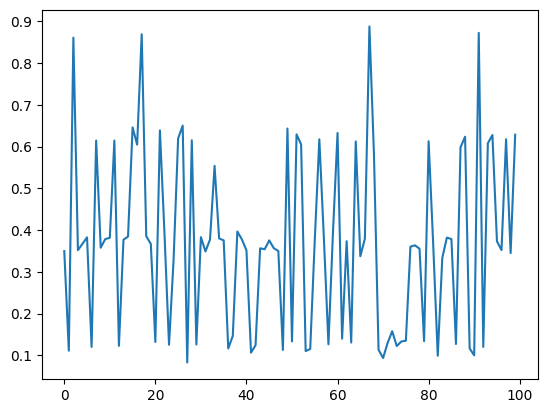

In [81]:
classic.to(device)
classic.train()
loss = nn.L1Loss()
loss.requires_grad_ = True
epochs = 100

print(f'Epochs : {epochs}, batch size : {batch_size}.')

losses = []
for epoch in tqdm(range(epochs)):
    
    for batch_num, input_data in enumerate(train_loader):

        batch_loss = []
        
        optimizer.zero_grad()
        
        x, y = input_data
        x = x.to(device)
        y = y.to(device)
        
        output = classic(x=x)
        output.requires_grad_(requires_grad=True)
        
        error = loss(output, y)
        error.requires_grad_(requires_grad=True)
        error.backward()
        
        batch_loss.append(error.item())
        
        optimizer.step()
        
    losses.append(sum(batch_loss)/len(batch_loss))

plt.plot(losses)

Epochs : 100, batch size : 100.


100%|██████████| 100/100 [00:36<00:00,  2.71it/s]


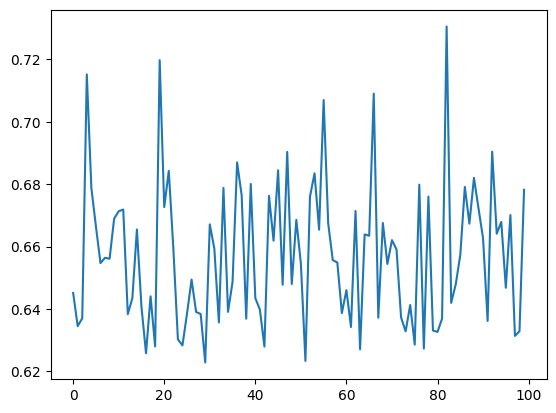

In [83]:
classic.to(device)
classic.train()
loss = nn.L1Loss()
loss.requires_grad_ = True
epochs = 100

print(f'Epochs : {epochs}, batch size : {batch_size}.')

losses = []
for epoch in tqdm(range(epochs)):
    
    for batch_num, input_data in enumerate(train_loader):

        batch_loss = []
        
        optimizer.zero_grad()
        
        x, y = input_data
        x = x.to(device)
        y = y.to(device)
        
        output = classic(x=x)
        output.requires_grad_(requires_grad=True)
        
        error = nn.functional.binary_cross_entropy_with_logits(output, y)

        error.requires_grad_(requires_grad=True)
        error.backward()
        
        batch_loss.append(error.item())
        
        optimizer.step()
        
    losses.append(sum(batch_loss)/len(batch_loss))

plt.plot(losses)

Epochs : 100, batch size : 100.


100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


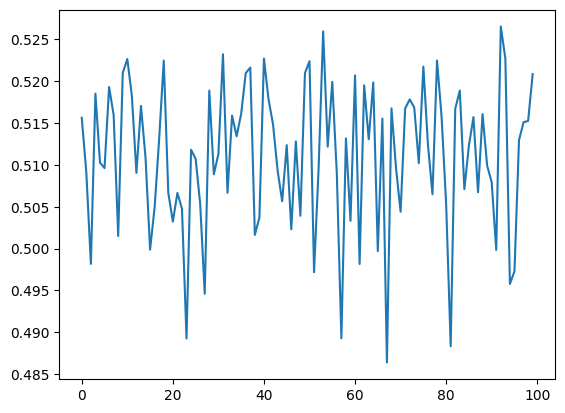

In [ ]:
# From notebook :

model.to(device)
model.train()
loss = nn.L1Loss()
loss.requires_grad_ = True
epochs = 100
print(f'Epochs : {epochs}, batch size : {batch_size}.')

losses = []
for epoch in tqdm(range(epochs)):

    for batch_num, input_data in enumerate(train_loader):

        batch_loss = []

        optimizer.zero_grad()

        x, y = input_data
        x = x.to(device)
        y = y.to(device)

        output = model(x=x)
        output.requires_grad_(requires_grad=True)

        error = loss(output, y)
        error.requires_grad_(requires_grad=True)
        error.backward()

        batch_loss.append(error.item())

        optimizer.step()

    losses.append(sum(batch_loss)/len(batch_loss))

plt.plot(losses)

# Test on easy datas (moved on colab : https://colab.research.google.com/drive/1-uHGR_4q5mGwMPkXQfqJ4Dbb5V6SGCr6)

In [ ]:
import numpy as np
import pandas as pd

# Fonction pour générer des tenseurs aléatoires de taille 10
def generate_random_tensor():
    return tonp.random.rand(input_size)

# Fonction pour déterminer si la somme des coordonnées du tenseur est supérieure à 5
def sum_greater_than_mean(tensor, input_size):
    return np.sum(tensor) > input_size/2

# Générer les tenseurs pour la colonne 'X'
tensors_X = [generate_random_tensor() for _ in range(100)]  # Générer 100 tenseurs

# Calculer les valeurs pour la colonne 'Y'
values_Y = [sum_greater_than_mean(tensor, input_size) for tensor in tensors_X]

# Créer le DataFrame
df = pd.DataFrame({'X': tensors_X, 'Y': values_Y})

# Afficher les 5 premières lignes du DataFrame
display(df)

x_easy = torch.stack(list(df['X']))
y_easy = torch.tensor(df['y'], dtype=torch.float32).unsqueeze(dim=1)
print(x_easy[0].dtype)
print(y_easy[0].dtype)

NameError: name 'tonp' is not defined

In [ ]:


X_train_easy, X_test_easy, y_train_easy, y_test_easy = train_test_split(x_easy, y_easy, test_size=0.2)

train_dataset_easy = TensorDataset(X_train_easy, y_train_easy)
train_loader_easy = DataLoader(train_dataset_easy, batch_size=batch_size, shuffle=True)

test_dataset_easy = TensorDataset(X_test_easy, y_test_easy)
test_loader_easy = DataLoader(test_dataset_easy, batch_size=batch_size, shuffle=True)

print(next(iter(train_loader_easy)))

optimizer = torch.optim.Adam(lr = 0.1, params=classic.parameters())
criterion = nn.CrossEntropyLoss()

classic.to(device)
classic.train()
loss = nn.L1Loss()
loss.requires_grad_ = True
epochs = 100
print(f'Epochs : {epochs}, batch size : {batch_size}.')

losses = []
for epoch in range(epochs):
    
    for batch_num, input_data in enumerate(train_loader_easy):

        batch_loss = []
        
        optimizer.zero_grad()
        
        x, y = input_data
        x = x.to(device)
        y = y.to(device)
        
        output = classic(x=x)
        output.requires_grad_(requires_grad=True)
        
        error = loss(output, y)
        error.requires_grad_(requires_grad=True)
        error.backward()
        
        batch_loss.append(error.item())
        
        optimizer.step()
        
    losses.append(sum(batch_loss)/len(batch_loss))

plt.plot(losses)

Accuracy : 0.237275


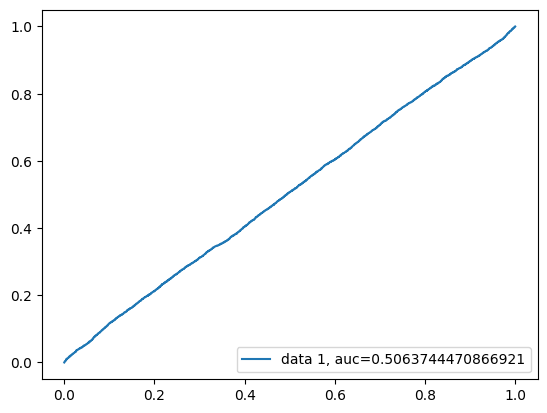

Accuracy : 0.2324


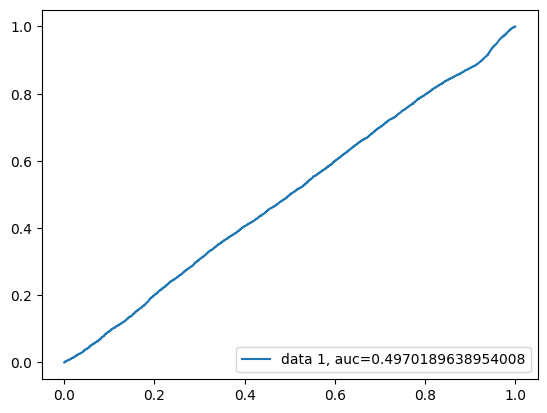

(0.2324,
 array([0.00000000e+00, 3.11944349e-05, 9.35833047e-05, ...,
        9.99937611e-01, 9.99968806e-01, 1.00000000e+00]),
 array([0.       , 0.       , 0.       , ..., 0.9998741, 1.       ,
        1.       ]),
 array([       inf, 0.5628371 , 0.5569319 , ..., 0.48338598, 0.4824607 ,
        0.4808096 ], dtype=float32))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_model(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    labels = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)
            predictions.extend(outputs.cpu().numpy())
            labels.extend(targets.cpu().numpy())

    # Convert predictions and labels to numpy arrays
    predictions = np.array(predictions)
    labels = np.array(labels)

    # Calculate accuracy
    accuracy = accuracy_score(labels, predictions.round())

    print('Accuracy :', accuracy)

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(labels, predictions)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr,tpr,label="data 1, auc="+str(roc_auc))
    plt.legend(loc=4)
    plt.show()

    return accuracy, fpr, tpr, thresholds

evaluate_model(model = untrained, data_loader=train_loader)
evaluate_model(model = classic, data_loader=train_loader)


In [ ]:
evaluate_model(model = classic, data_loader=train_loader)

# OLD

In [ ]:
def lin_cross_entropy(x, y,
             possibles_tails_for_embed_head_rel_doubles,
             entity_product_embedding_to_ID,
             relation_product_embedding_to_ID,
             ontology,
             lin_importance = 0.3,
             error_return = 0
             ):
             
    log_prob = -1.0 * torch.nn.functional.log_softmax(x, 1)
    loss = log_prob.gather(1, y.unsqueeze(1))-torch.tensor(lin_importance*(1-best_lin_similarities_for_elements_of_batch(
             x,
             possibles_tails_for_embed_head_rel_doubles,
             entity_product_embedding_to_ID,
             relation_product_embedding_to_ID,
             ontology,
             error_return=0)))

    loss = loss.mean()
    return loss

def cross_entropy(x, y):
    # Add an extra dimension to the tensor
    x = x.unsqueeze(0)
    log_prob = -1.0 * torch.nn.functional.log_softmax(x, 1).transpose(0, 1)
    loss = log_prob.gather(0, y.unsqueeze(0).view())
    loss = loss.mean()
    return loss

x = torch.tensor([0.4801, 0.4799, 0.4811, 0.4796, 0.4792, 0.4791, 0.4797, 0.4800, 0.4806,
        0.4789, 0.4800, 0.4803, 0.4802, 0.4796, 0.4803, 0.4800, 0.4793, 0.4798,
        0.4802, 0.4805, 0.4795, 0.4801, 0.4803, 0.4805, 0.4808, 0.4796, 0.4805,
        0.4803, 0.4800, 0.4793, 0.4796, 0.4801, 0.4797, 0.4806, 0.4806, 0.4800,
        0.4803, 0.4800, 0.4807, 0.4805, 0.4803, 0.4798, 0.4791, 0.4796, 0.4785,
        0.4801, 0.4798, 0.4793, 0.4808, 0.4798, 0.4793, 0.4796, 0.4803, 0.4803,
        0.4798, 0.4801, 0.4799, 0.4802, 0.4797, 0.4803, 0.4795, 0.4803, 0.4795,
        0.4799])
y = torch.tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0])
print(x.shape, y.shape)
cross_entropy(x,y)


# Can we calcultate lin loss ?

criterion = nn.CrossEntropyLoss()
batch_size = 5
nb_classes = 10
x = ts
y = tl

print(x.shape, y.shape)

loss_reference = criterion(x, y)
loss = lin_cross_entropy(x = x, y = y,
                         possibles_tails_for_embed_head_rel_doubles = possibles_tails_with_product_keys,
                         entity_product_embedding_to_ID = entity_product_embedding_to_ID,
                         relation_product_embedding_to_ID = relation_product_embedding_to_ID,
                         ontology=nxo)

print(loss_reference - loss)

loss = cross_entropy(x = x, y = y)

print(loss_reference - loss)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convertir les données en tenseurs PyTorch
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val, batch_size=batch_size)
test_loader = DataLoader(test, batch_size=batch_size)

In [ ]:


def train_model(model, criterion, optimizer, train_loader, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch_idx, (data, targets) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss}')

def validate_model(model, criterion, val_loader):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data, targets in val_loader:
            outputs = model(data)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    print(f'Validation Loss: {val_loss}')

# Exemple d'utilisation
input_size = 6 * hidden_channels  
hidden_size = 128  
output_size = 1

untrained, classic, special = MLP(input_size, hidden_size, output_size), MLP(input_size, hidden_size, output_size), MLP(input_size, hidden_size, output_size)

optimizer = optim.Adam(classic.parameters(), lr=0.001)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val, batch_size=batch_size)

num_epochs = 10

print("Untrained Model:")
validate_model(untrained, cross_entropy, val_loader)

print("\nTraining Classic Model:")
train_model(classic, cross_entropy, optimizer, train_loader, num_epochs)
validate_model(classic, cross_entropy, val_loader)

print("\nTraining Special Model:")
train_model(special, lin_cross_entropy, optimizer, train_loader)
validate_model(classic, cross_entropy, val_loader)



Untrained Model:


KeyError: 0

## Test

# Depr

In [ ]:
entity_product_embedding_to_ID = {k:mapping_to_entity[v] for k, v in product_entities_embedding_to_mapping.items()}
get_key_value_pair(entity_product_embedding_to_ID)

(-1.2316684563401905e-05, 'GO:0008081')

In [ ]:
def check_dict_chain(dicts:list, number_of_tests: int = 1):
    '''
    Parameters :
    -
    Returns :
    - 
    '''
    lengths = [len(dict) for dict in dicts]

    print(f'All dicts have the same size : {lengths.count(lengths[0])==len(lengths)}.') # Checking efficiently that all dicts have the same size
    for i in range(number_of_tests):
        found_no_error = False
        initial_key = random.choice(list(dicts[0].keys()))
        key = initial_key
        keys:list = [initial_key]
        for dict in dicts:
            try:
                key=dict[key]
                keys.append(key)
            except:
                raise KeyError(f"problem with key : {key} with type : {type(key)}.\nKeys list : {keys}\nProblematic dict :\n{dict}")
        print(f"Final key is equal initial key : {key == initial_key}.\nPath : {keys}")


In [ ]:


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Définition de la taille des données
num_samples = 1000
input_size = 10
hidden_size = 20
output_size = 1
batch_size = 32

# Création de données simulées
X_train = torch.randn(num_samples, input_size)
y_train = torch.randint(0, 2, (num_samples, output_size)).float()  # Génération de labels binaires aléatoires

# Création de DataLoader pour gérer les batchs
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Définition du modèle
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

model = MLP(input_size, hidden_size, output_size)

# Définition de la fonction de perte et de l'optimiseur
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Boucle d'entraînement
num_epochs = 100
for epoch in range(num_epochs):
    # Entraînement du modèle
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        print(type(input), inputs.size())
        loss.backward()
        optimizer.step()


        print(f'Epoch [{epoch+1}/{num_epochs}]')

# Évaluation du modèle
model.eval()
with torch.no_grad():
  total_correct = 0
  total_samples = 0
  for inputs, targets in train_loader:
    outputs = model(inputs)
    predicted = (outputs > 0.5).float()
    total_correct += (predicted == targets).sum().item()
    total_samples += targets.size(0)

    accuracy = total_correct / total_samples
    print(accuracy)

print("Entraînement terminé!")


<class 'method'> torch.Size([32, 10])


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn